# Zonal averaged Surface CO2 upward flux

`cd project/seniorthesis/notebooks`

`conda list PyCO2SYS`

`pip install PyCO2SYS`

`pip install git+https://github.com/jbusecke/cmip6_preprocessing.git`

`mv *.png ../figures`

In [1]:
from scipy.io import loadmat
import xarray as xr
import xesmf as xe
from cmip6_preprocessing.preprocessing import combined_preprocessing
import PyCO2SYS as pyco2 # i have to install this package through terminal for it to work
import intake
import matplotlib.pyplot as plt
import numpy as np
import warnings
import gsw
from cmip6_preprocessing.postprocessing import combine_datasets
from cartopy import crs as ccrs
import cartopy.feature as cfeature
from cartopy.util import add_cyclic_point
import cmocean
import matplotlib.path as mpath
from cmip6_preprocessing.postprocessing import combine_datasets
from cmip6_preprocessing.postprocessing import merge_variables
from dask.diagnostics import ProgressBar
from xgcm import Grid
from xhistogram.xarray import histogram
import pandas as pd
from scipy.io import netcdf
import netCDF4 as nc


In [2]:
col = intake.open_esm_datastore("https://storage.googleapis.com/cmip6/pangeo-cmip6.json")

## Area

In [3]:
def pick_first_member(ds_list, **kwargs):
    return ds_list[0]

variables = ['areacello']
z_kwargs = {'consolidated': True, 'use_cftime': True}
query = dict(experiment_id=['historical'], 
             table_id=['Ofx'], 
             variable_id=variables,
             grid_label=['gr'],
              source_id=['GFDL-ESM4']
            )


cat = col.search(**query)

# print(cat.df['source_id'].unique())
dd_A = cat.to_dataset_dict(zarr_kwargs=z_kwargs, storage_options={'token': 'anon'},
                                preprocess=combined_preprocessing, aggregate=False)


--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.member_id.table_id.variable_id.grid_label.zstore.dcpp_init_year.version'


In [4]:
# pick first member in case there are multiple members
dd_A = combine_datasets(
    dd_A,
    pick_first_member,
    match_attrs=['source_id', 'grid_label', 'experiment_id', 'table_id']
)
list(dd_A.keys())
# dd_new_new_gr

['GFDL-ESM4.gr.historical.Ofx']

## Get datasets and calculate variables

In [5]:
dd = {}
dd['UKESM1-0-LL.gn.historical.Omon'] = xr.open_mfdataset('UKESM1_*_20yr.nc')
dd['CanESM5-CanOE.gn.historical.Omon']= xr.open_mfdataset('CanESM5CanOE*_20yr.nc')
dd['CNRM-ESM2-1.gn.historical.Omon']= xr.open_mfdataset('CNRM*_20yr.nc')
dd['CanESM5.gn.historical.Omon']= xr.open_mfdataset('CanESM5_*_20yr.nc')
dd['IPSL-CM6A-LR.gn.historical.Omon']= xr.open_mfdataset('IPSL*_20yr.nc')
dd['CESM2-WACCM.gr.historical.Omon']= xr.open_mfdataset('CESM2-WACCM_*_20yr.nc')
dd['CESM2.gr.historical.Omon']= xr.open_mfdataset('CESM2_*_20yr.nc')
dd['CESM2-WACCM-FV2.gr.historical.Omon']= xr.open_mfdataset('CESM2-WACCM-FV2_*_20yr.nc')
dd['GFDL-ESM4.gr.historical.Omon']= xr.open_mfdataset('GFDL-ESM4_*_20yr.nc')
dd['CESM2-FV2.gr.historical.Omon']= xr.open_mfdataset('CESM2-FV2_*_20yr.nc')
dd['GFDL-CM4.gr.historical.Omon']= xr.open_mfdataset('GFDL-CM4_*_20yr.nc')
dd['MRI-ESM2-0.gr.historical.Omon']= xr.open_mfdataset('MRI-ESM2-0_*_20yr.nc')
# A = xr.open_mfdataset('AREA.nc')

In [6]:
for name, ds in dd.items():
    ds['p'] = gsw.p_from_z(-1*ds['lev'], ds['y'], geo_strf_dyn_height=0, sea_surface_geopotential=0)*xr.ones_like(ds['talk']) # expand along time dimension
    ds['insitutemp'] = gsw.t_from_CT(ds['so'], ds['thetao'], ds['p'])
    ds['sigma2'] = gsw.sigma2(ds['so'],ds['thetao'])
    ds['sigma0'] = gsw.sigma0(ds['so'],ds['thetao'])

## Reassign coords in `dd` so that it matches up with coords from `areacello`

In [7]:
newcoords = {'x':dd_A['GFDL-ESM4.gr.historical.Ofx'].areacello['x'], 'y':dd_A['GFDL-ESM4.gr.historical.Ofx'].areacello['y']}
newcoords

{'x': <xarray.DataArray 'x' (x: 360)>
 array([  0.5,   1.5,   2.5, ..., 357.5, 358.5, 359.5])
 Coordinates:
   * x        (x) float64 0.5 1.5 2.5 3.5 4.5 ... 355.5 356.5 357.5 358.5 359.5
 Attributes:
     axis:           X
     bounds:         lon_bnds
     cell_methods:   time: point
     long_name:      longitude
     standard_name:  longitude
     units:          degrees_E,
 'y': <xarray.DataArray 'y' (y: 180)>
 array([-89.5, -88.5, -87.5, -86.5, -85.5, -84.5, -83.5, -82.5, -81.5, -80.5,
        -79.5, -78.5, -77.5, -76.5, -75.5, -74.5, -73.5, -72.5, -71.5, -70.5,
        -69.5, -68.5, -67.5, -66.5, -65.5, -64.5, -63.5, -62.5, -61.5, -60.5,
        -59.5, -58.5, -57.5, -56.5, -55.5, -54.5, -53.5, -52.5, -51.5, -50.5,
        -49.5, -48.5, -47.5, -46.5, -45.5, -44.5, -43.5, -42.5, -41.5, -40.5,
        -39.5, -38.5, -37.5, -36.5, -35.5, -34.5, -33.5, -32.5, -31.5, -30.5,
        -29.5, -28.5, -27.5, -26.5, -25.5, -24.5, -23.5, -22.5, -21.5, -20.5,
        -19.5, -18.5, -17.5, -16.5,

In [8]:
for name, ds in dd.items():
    dd[name] = ds.assign_coords(**newcoords)

## Dictionary for plot colors

In [9]:
model_kwargs = {}
model_kwargs['UKESM1-0-LL.gn.historical.Omon'] = {'color': '#8f5904'}
model_kwargs['CanESM5-CanOE.gn.historical.Omon'] = {'color': '#a1a1a1'}
model_kwargs['CNRM-ESM2-1.gn.historical.Omon'] = {'color': '#cc0000'}
model_kwargs['CanESM5.gn.historical.Omon'] = {'color': '#ff8200'}
model_kwargs['IPSL-CM6A-LR.gn.historical.Omon'] = {'color': '#f1c232'}
model_kwargs['CESM2-WACCM.gr.historical.Omon'] = {'color': '#8fce00'}
model_kwargs['CESM2.gr.historical.Omon'] = {'color': '#20b2aa'}
model_kwargs['CESM2-WACCM-FV2.gr.historical.Omon'] = {'color': '#66ccff'}
model_kwargs['GFDL-ESM4.gr.historical.Omon'] = {'color': '#674ea7'}
model_kwargs['GFDL-CM4.gr.historical.Omon'] = {'color': '#800080'}
model_kwargs['MRI-ESM2-0.gr.historical.Omon'] = {'color': '#ff80ed'}
model_kwargs['CESM2-FV2.gr.historical.Omon'] = {'color': '#024c8f'}

## Plot plot plot

In [10]:
# define an A 
A = dd_A['GFDL-ESM4.gr.historical.Ofx'].areacello
A2 = dd_A['GFDL-ESM4.gr.historical.Ofx'].areacello.mean(['x'],keep_attrs=True)

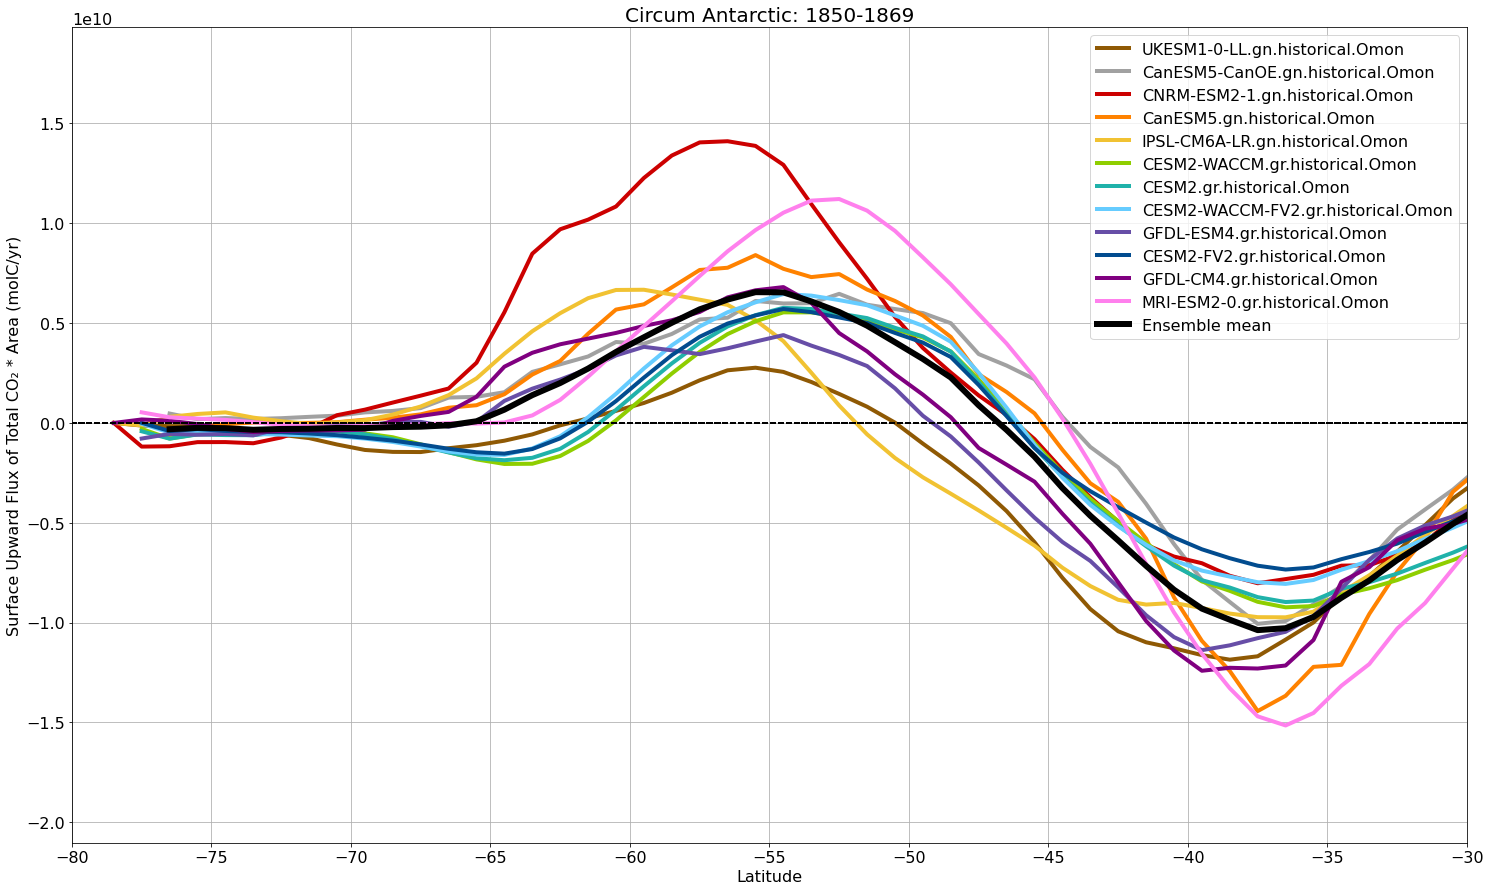

In [12]:
plt.rc('font', size = 16)
plt.rc('axes', titlesize= 16)    
plt.rc('axes', labelsize= 16)
plt.rc('figure', titlesize=16)

temp = {}

conversion = 3.1536e7 * 83.3
for name, ds in dd.items():
    # multiply by conversion and A
    # multiply by -1 so it is surf UPWARD flux
    d = -1*ds.fgco2*A*conversion
    d = d.mean(['x'],keep_attrs=True)
    ar = d
    # d = -1*ds.fgco2.mean(['x'],keep_attrs=True)*conversion
    # # d = d.mean(['x'],keep_attrs=True)*conversion
    # ar = d*A2
    
    # put into a temp array so I can eventually take a mean of temp members
    temp[name]=ar
    
# plots the individual models .sel(y = slice(-80, -30))
for name, ds in temp.items():
    plt.plot(ds.y, ds, label = name, lw = 4, **model_kwargs[name])
    plt.xlabel('Latitude')
    plt.ylabel('Surface Upward Flux of Total CO\u2082 (molC/m\u00b2/yr)')

# take the mean of temp and plot
mn = np.mean(list(temp.values()), axis=0)
plt.plot(ds.y, mn, lw = 6, label = 'Ensemble mean', color = 'black')
plt.xlabel('Latitude')
plt.ylabel('Surface Upward Flux of Total CO\u2082 (molC/m\u00b2/yr)')

zr = xr.zeros_like(dd['CESM2-FV2.gr.historical.Omon'].fgco2)
plt.plot(zr.y, zr, linestyle = 'dashed', color = 'black')
plt.xlabel('Latitude', fontsize = 16)
plt.ylabel('Surface Upward Flux of Total CO\u2082 * Area (molC/yr)', fontsize = 16)
plt.xlim([-80,-30])
plt.xticks([-80, -75, -70, -65, -60, -55, -50, -45, -40, -35, -30])
plt.grid()
# plt.ylim([-5e19, 5e19])
plt.legend(
#     bbox_to_anchor=(1.05, 1), 
    loc='upper right', fontsize = 16
#     , borderaxespad=0.
)
plt.title('Circum Antarctic: 1850-1869', fontsize = 20)
plt.rcParams["figure.figsize"] = (25,15)

## Total outgassed CO2
Just summing the area integrated flux where it is positive (above)

In [13]:
fgco2_sums = {}

for name, ds in temp.items():
    ds = ds.sel(y = slice(-80, -30))
    fgco2_sums[name] = sum(np.where(ds>0, ds, 0))/1e9
    # plt.plot(ds.y, np.where(ds>0, ds, 0))
    # fgco2_sums[name]
    

# sum(res)
fgco2_sums


{'UKESM1-0-LL.gn.historical.Omon': 17.7842381383661,
 'CanESM5-CanOE.gn.historical.Omon': 95.28173947373998,
 'CNRM-ESM2-1.gn.historical.Omon': 174.15310155162018,
 'CanESM5.gn.historical.Omon': 105.6928844055293,
 'IPSL-CM6A-LR.gn.historical.Omon': 70.96759154880058,
 'CESM2-WACCM.gr.historical.Omon': 53.953982848,
 'CESM2.gr.historical.Omon': 57.063064704,
 'CESM2-WACCM-FV2.gr.historical.Omon': 67.256844736,
 'GFDL-ESM4.gr.historical.Omon': 46.569840652,
 'CESM2-FV2.gr.historical.Omon': 57.145036399,
 'GFDL-CM4.gr.historical.Omon': 75.156937,
 'MRI-ESM2-0.gr.historical.Omon': 125.553581444}

In [14]:

clrs = {'UKESM1-0-LL.gn.historical.Omon': '#8f5904',
        'CanESM5-CanOE.gn.historical.Omon': '#a1a1a1',
        'CNRM-ESM2-1.gn.historical.Omon': '#cc0000',
        'CanESM5.gn.historical.Omon':'#ff8200',
        'IPSL-CM6A-LR.gn.historical.Omon': '#f1c232',
        'CESM2-WACCM.gr.historical.Omon': '#8fce00',
        'CESM2.gr.historical.Omon': '#20b2aa',
        'CESM2-WACCM-FV2.gr.historical.Omon': '#66ccff',
        'GFDL-ESM4.gr.historical.Omon': '#674ea7',
        'CESM2-FV2.gr.historical.Omon': '#024c8f',
        'GFDL-CM4.gr.historical.Omon': '#800080',
        'MRI-ESM2-0.gr.historical.Omon': '#ff80ed',}

clr = ['#8f5904',
        '#a1a1a1',
        '#cc0000',
        '#ff8200',
        '#f1c232',
        '#8fce00',
        '#20b2aa',
        '#66ccff',
        '#674ea7',
        '#024c8f',
        '#800080',
        '#ff80ed'
        ]

Text(0, 0.5, 'Total CO₂ Outgas (GmolC/yr)')

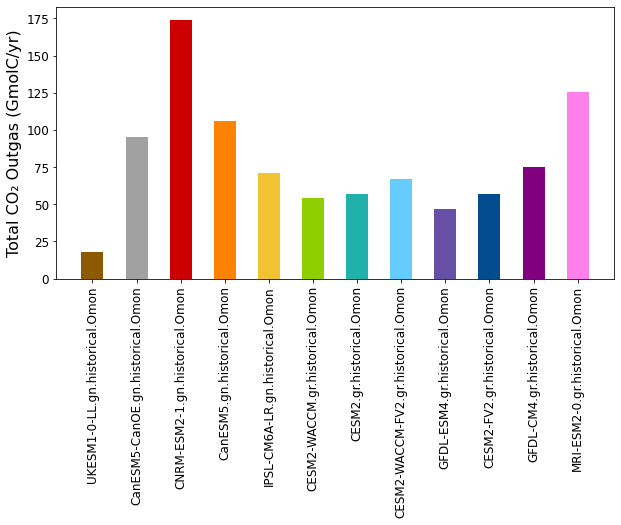

In [15]:
plt.rc('font', size = 12)
plt.rc('axes', titlesize= 16)    
plt.rc('axes', labelsize= 16)
plt.rc('figure', titlesize=16)

models = list(fgco2_sums.keys())
values = list(fgco2_sums.values())
fig = plt.figure(figsize = (10, 5))
#  Bar plot
plt.bar(models,values,
        width = 0.5, color = clr)
plt.xticks(rotation = 90)
# plt.xlabel("CMIP6 Models")
plt.ylabel('Total CO\u2082 Outgas (GmolC/yr)')
# plt.title("Students enrolled in different courses")
# plt.show()

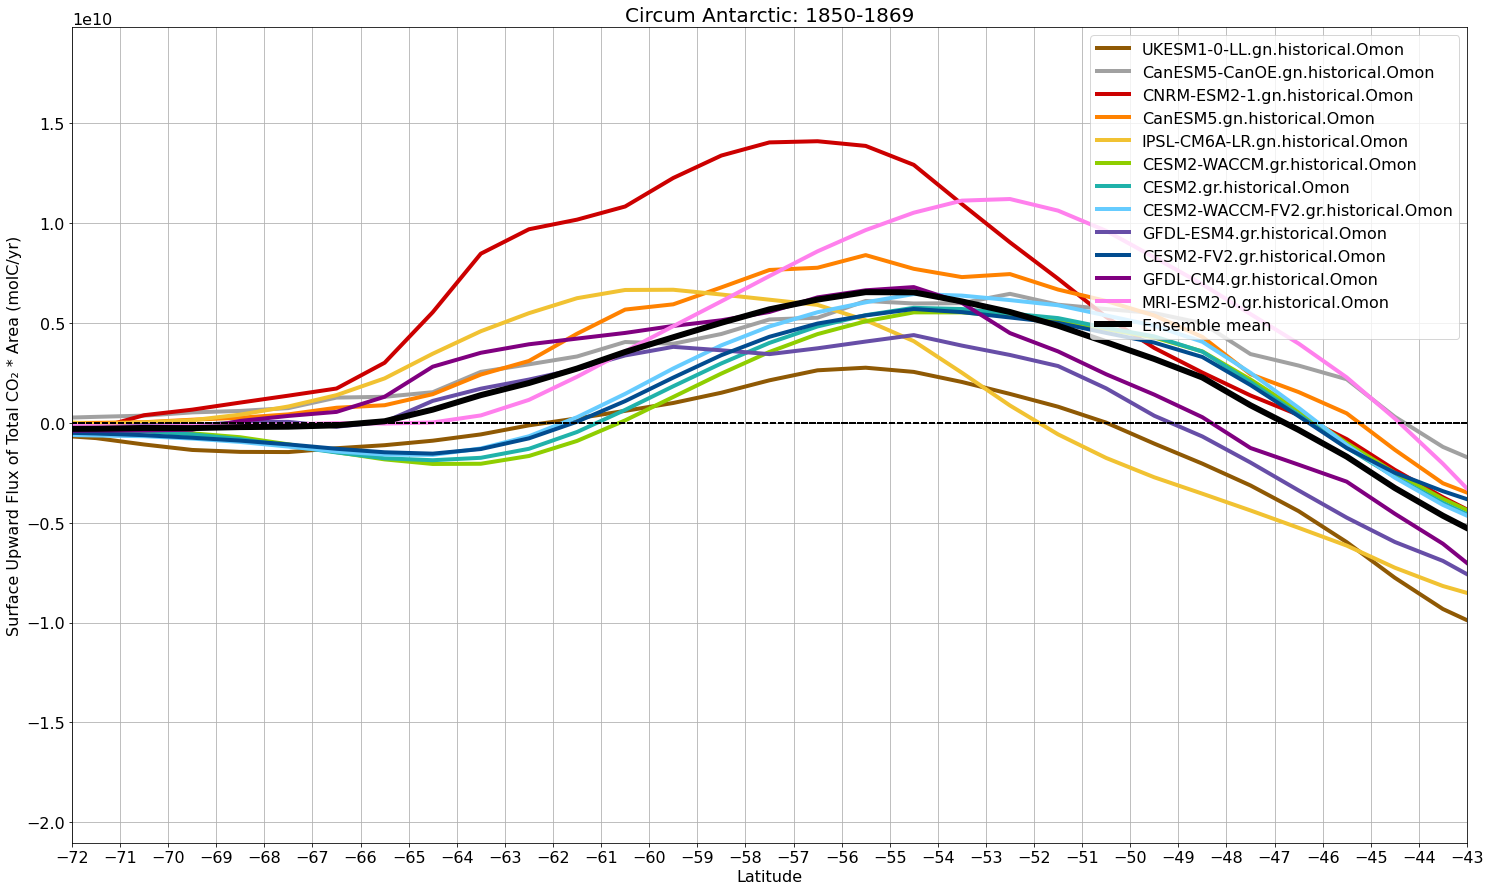

In [16]:
plt.rc('font', size = 16)
plt.rc('axes', titlesize= 16)    
plt.rc('axes', labelsize= 16)
plt.rc('figure', titlesize=16)

temp = {}

conversion = 3.1536e7 * 83.3
for name, ds in dd.items():
    # multiply by conversion and A
    # multiply by -1 so it is surf UPWARD flux
    d = -1*ds.fgco2*A*conversion
    d = d.mean(['x'],keep_attrs=True)
    ar = d
    # d = -1*ds.fgco2.mean(['x'],keep_attrs=True)*conversion
    # # d = d.mean(['x'],keep_attrs=True)*conversion
    # ar = d*A2
    
    # put into a temp array so I can eventually take a mean of temp members
    temp[name]=ar
    
# plots the individual models .sel(y = slice(-80, -30))
for name, ds in temp.items():
    plt.plot(ds.y, ds, label = name, lw = 4, **model_kwargs[name])
    plt.xlabel('Latitude')
    plt.ylabel('Surface Upward Flux of Total CO\u2082 (molC/m\u00b2/yr)')

# take the mean of temp and plot
mn = np.mean(list(temp.values()), axis=0)
plt.plot(ds.y, mn, lw = 6, label = 'Ensemble mean', color = 'black')
plt.xlabel('Latitude')
plt.ylabel('Surface Upward Flux of Total CO\u2082 (molC/m\u00b2/yr)')

zr = xr.zeros_like(dd['CESM2-FV2.gr.historical.Omon'].fgco2)
plt.plot(zr.y, zr, linestyle = 'dashed', color = 'black')
plt.xlabel('Latitude', fontsize = 16)
plt.ylabel('Surface Upward Flux of Total CO\u2082 * Area (molC/yr)', fontsize = 16)
plt.xlim([-72,-43])
plt.xticks([-72., -71., -70., -69., -68., -67., -66., -65., -64., -63., -62.,
       -61., -60., -59., -58., -57., -56., -55., -54., -53., -52., -51.,
       -50., -49., -48., -47., -46., -45., -44., -43.])
plt.grid()
# plt.ylim([-5e19, 5e19])
plt.legend(
#     bbox_to_anchor=(1.05, 1), 
    loc='upper right', fontsize = 16
#     , borderaxespad=0.
)
plt.title('Circum Antarctic: 1850-1869', fontsize = 20)
plt.rcParams["figure.figsize"] = (25,15)

In [18]:
np.linspace(-72, -43, 30)

array([-72., -71., -70., -69., -68., -67., -66., -65., -64., -63., -62.,
       -61., -60., -59., -58., -57., -56., -55., -54., -53., -52., -51.,
       -50., -49., -48., -47., -46., -45., -44., -43.])